# Build a LLM-powered Chatbot in LangGraph

## Learning Objectives
By the end of this notebook, you will be able to:
1. **Integrate LLMs into LangGraph** - Connect language models to your graph nodes
2. **Build a functional chatbot** - Create an end-to-end conversational AI
3. **Understand invoke vs. stream** - Learn different ways to run your graph
4. **Handle message types** - Work with HumanMessage and AIMessage objects

## What We're Building
A simple but complete LLM-powered chatbot that:
- Receives user messages
- Sends them to an LLM (Groq/OpenAI)
- Returns the AI response

```
┌─────────────────────────────────────────────────────────────────┐
│                    CHATBOT ARCHITECTURE                         │
├─────────────────────────────────────────────────────────────────┤
│                                                                  │
│    User Input ──► [chatbot node] ──► LLM ──► AI Response        │
│                        │                        │                │
│                        └────────────────────────┘                │
│                              (state update)                      │
│                                                                  │
└─────────────────────────────────────────────────────────────────┘
```

LangGraph is not just a framework to create static graphs. We already know that it can be used for building stateful, agentic applications using LLMs.

We'll now create a simple LLM-powered chatbot using LangGraph. This chatbot will respond directly to user messages.

![](https://i.imgur.com/heeggTe.png)

In [1]:
# ============================================================================
# SETUP: Import LLM Helper Functions
# ============================================================================
# We use helper functions to create LLM instances with proper configuration
# These functions handle API key loading and model configuration

import os
import sys

# Add parent directory to path for importing helpers
sys.path.append(os.path.abspath(".."))

# Import our LLM factory functions
# - get_groq_llm(): Creates a Groq-hosted LLM (fast inference)
# - get_openai_llm(): Creates an OpenAI GPT model
from helpers.utils import get_groq_llm, get_openai_llm

print("LLM helpers imported successfully!")

## Step 1: Define the State

For a chatbot, we need to track the **conversation history** - all messages exchanged between user and AI.

### Why Conversation History Matters
- LLMs are **stateless** - they don't remember previous messages
- We must send the **full conversation** with each request
- The `add_messages` reducer automatically **appends** new messages

### Message Types in LangChain
| Type | Description | Example |
|------|-------------|---------|
| `HumanMessage` | User's input | "What is AI?" |
| `AIMessage` | LLM's response | "AI is..." |
| `SystemMessage` | System instructions | "You are a helpful assistant" |
| `ToolMessage` | Tool call results | `{"result": "..."}` |

The State schema serves as the input schema for all Nodes and Edges in the graph.

Let's use the `TypedDict` class from python's `typing` module as our schema, which provides type hints for the keys.

In [2]:
# ============================================================================
# DEFINING CHATBOT STATE
# ============================================================================
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    """
    Chatbot State Schema.
    
    Attributes:
        messages: List of conversation messages (HumanMessage, AIMessage)
                 Uses add_messages reducer to append (not overwrite) messages
    
    The add_messages reducer is essential for chatbots because:
    1. It preserves the full conversation history
    2. Each new message is appended to the list
    3. The LLM can see all previous context
    """
    messages: Annotated[list, add_messages]  # Automatically appends new messages

## Step 2: Create the Chatbot Node and Graph

Now we'll create:
1. **LLM instance** - The language model that generates responses
2. **Chatbot node** - A function that calls the LLM with the current messages
3. **Graph** - Simple structure: START → chatbot → END

### How the Chatbot Node Works
```python
def chatbot(state):
    # 1. Get all messages from state
    messages = state["messages"]
    
    # 2. Send to LLM (includes full conversation history)
    response = llm.invoke(messages)
    
    # 3. Return response (will be appended to messages)
    return {"messages": [response]}
```

In [3]:
# ============================================================================
# CREATE THE LLM AND CHATBOT GRAPH
# ============================================================================

# -----------------------------------------------------------------------------
# Step 1: Initialize the LLM
# We use Groq for fast inference, but you can swap to OpenAI
# -----------------------------------------------------------------------------
llm = get_groq_llm()  # Fast, open-source models hosted by Groq
# Alternative: llm = get_openai_llm()  # OpenAI's GPT models

print(f"LLM initialized: {llm.model_name if hasattr(llm, 'model_name') else 'Groq LLM'}")

# -----------------------------------------------------------------------------
# Step 2: Define the chatbot node function
# This is where the magic happens - the LLM is called here
# -----------------------------------------------------------------------------
def chatbot(state: State):
    """
    The core chatbot node that calls the LLM.
    
    Process:
    1. Receives the full conversation history from state
    2. Sends all messages to the LLM for context
    3. Returns the AI response (which gets appended to messages)
    
    Args:
        state: Contains 'messages' - the full conversation history
        
    Returns:
        dict with 'messages' key containing the LLM's response
        The add_messages reducer will append this to existing messages
    """
    # Get current conversation history
    current_messages = state["messages"]
    
    # Call the LLM with the full conversation context
    # The LLM sees all previous messages for context
    ai_response = llm.invoke(current_messages)
    
    # Return as a list - add_messages reducer will append to state
    return {"messages": [ai_response]}

# -----------------------------------------------------------------------------
# Step 3: Build the graph
# Simple structure: START → chatbot → END
# -----------------------------------------------------------------------------
graph_builder = StateGraph(State)

# Add the chatbot node
graph_builder.add_node("chatbot", chatbot)

# Define the flow
graph_builder.add_edge(START, "chatbot")  # Entry: go to chatbot
graph_builder.add_edge("chatbot", END)     # Exit: end after chatbot responds

# Compile the graph
graph = graph_builder.compile()

print("Chatbot graph compiled successfully!")

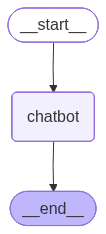

In [4]:
# ============================================================================
# VISUALIZE THE CHATBOT GRAPH
# ============================================================================
# The graph is simple: just one node that calls the LLM

from IPython.display import Image, display

print("Chatbot Graph Structure:")
print("-" * 40)
display(Image(graph.get_graph().draw_mermaid_png()))
print("-" * 40)
print("Flow: START → chatbot (LLM call) → END")

In [5]:
# ============================================================================
# TEST THE CHATBOT: Basic Invocation
# ============================================================================
# graph.invoke() runs the graph synchronously and returns the final state

print("=" * 60)
print("Testing Chatbot with: 'Explain AI in 2 bullet points'")
print("=" * 60)

# Invoke the graph with a user message
response = graph.invoke({"messages": "Explain AI in 2 bullet points"})

# Examine the response structure
print(f"\nResponse contains {len(response['messages'])} messages:")
for i, msg in enumerate(response['messages']):
    msg_type = type(msg).__name__
    print(f"  [{i}] {msg_type}: {msg.content[:50]}..." if len(msg.content) > 50 else f"  [{i}] {msg_type}: {msg.content}")

response

{'messages': [HumanMessage(content='Explain AI in 2 bullet points', additional_kwargs={}, response_metadata={}, id='f227f82e-10ec-40e3-90aa-c35641e43e30'),
  AIMessage(content='- **AI is the development of computer systems that can perform tasks requiring human‑like intelligence**, such as learning from data, recognizing patterns, making decisions, and understanding natural language.  \n- **It combines techniques like machine learning, deep learning, and symbolic reasoning** to enable machines to adapt, improve, and solve problems across domains—from image recognition and speech translation to autonomous vehicles and personalized recommendations.', additional_kwargs={'reasoning_content': 'The user wants a concise explanation of AI in 2 bullet points. Provide two bullet points summarizing AI. Should be clear.'}, response_metadata={'token_usage': {'completion_tokens': 115, 'prompt_tokens': 78, 'total_tokens': 193, 'completion_time': 0.244015292, 'completion_tokens_details': {'reasoning_t

In [6]:
# ============================================================================
# EXTRACT THE AI RESPONSE
# ============================================================================
# The last message in the list is always the most recent (AI's response)

print("=" * 60)
print("AI Response:")
print("=" * 60)
print(response['messages'][-1].content)

- **AI is the development of computer systems that can perform tasks requiring human‑like intelligence**, such as learning from data, recognizing patterns, making decisions, and understanding natural language.  
- **It combines techniques like machine learning, deep learning, and symbolic reasoning** to enable machines to adapt, improve, and solve problems across domains—from image recognition and speech translation to autonomous vehicles and personalized recommendations.


---

## Step 3: Invoking vs. Streaming in LangGraph

LangGraph provides two main ways to run your graph:

### `graph.invoke()` - Synchronous Execution
- Runs the **entire graph** and returns the **final state**
- Waits for completion before returning
- Best for: Simple use cases, batch processing

### `graph.stream()` - Streaming Execution  
- Returns an **iterator** that yields **intermediate states**
- Shows progress as each node completes
- Best for: Real-time UIs, long-running workflows

### Stream Modes

| Mode | What it yields | Use case |
|------|----------------|----------|
| `'values'` | Full state after each node | See complete state evolution |
| `'updates'` | Only the changes from each node | Efficient for large states |

```
invoke():  [wait...wait...wait...] → Final Result

stream():  Node1 → Node2 → Node3 → ... (real-time updates)
```

In [7]:
# ============================================================================
# INVOKE: Get final result in one call
# ============================================================================
# invoke() waits for the entire graph to complete before returning

print("=" * 60)
print("Using graph.invoke() - Synchronous Execution")
print("=" * 60)

response = graph.invoke({"messages": "Explain AI in 1 line to a child"})

print("Response received after graph completion:")
print("-" * 40)
print(response['messages'][-1].content)

AI is like a smart robot brain that learns to help you do things, just like a friendly helper that gets better the more it plays and learns.


In [8]:
# ============================================================================
# IMPORTANT: Each invoke() is a NEW conversation!
# ============================================================================
# Note: Each call to invoke() starts with a FRESH state
# The LLM doesn't remember previous invoke() calls

print("=" * 60)
print("Testing Memory: 'What did we discuss so far?'")
print("=" * 60)

response = graph.invoke({"messages": "What did we discuss so far?"})
print(response['messages'][-1].content)

print("\n" + "-" * 60)
print("NOTE: The LLM doesn't remember previous conversations!")
print("Each invoke() call starts fresh. For true multi-turn chat,")
print("you need to pass the full conversation history each time,")
print("or use LangGraph's checkpointing/persistence features.")

We haven’t covered any specific topics yet—this is the first question you’ve asked in our conversation. Is there something particular you’d like to discuss or ask about?


In [9]:
# ============================================================================
# STREAM MODE: 'values' - See full state after each node
# ============================================================================
# stream_mode='values' yields the COMPLETE state after each node executes

print("=" * 60)
print("Using graph.stream() with stream_mode='values'")
print("=" * 60)
print("This shows the full messages list after each step:\n")

step = 0
for event in graph.stream({"messages": "Explain AI in 1 line to a child"},
                          stream_mode='values'):
    step += 1
    print(f"Step {step}: {len(event['messages'])} message(s)")
    print("-" * 40)
    
    # Show each message in the current state
    for i, msg in enumerate(event['messages']):
        msg_type = type(msg).__name__
        content = msg.content if hasattr(msg, 'content') else str(msg)
        print(f"  [{i}] {msg_type}: {content[:80]}{'...' if len(content) > 80 else ''}")
    print()

[HumanMessage(content='Explain AI in 1 line to a child', additional_kwargs={}, response_metadata={}, id='47d10bc1-b98d-420a-99e4-f02426bdd2fd')]
[HumanMessage(content='Explain AI in 1 line to a child', additional_kwargs={}, response_metadata={}, id='47d10bc1-b98d-420a-99e4-f02426bdd2fd'), AIMessage(content='AI is like a smart robot brain that learns to help you do things, just like a friendly helper that gets better the more it plays and learns.', additional_kwargs={'reasoning_content': 'We need to respond with a single line explanation suitable for a child. Should be simple.'}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 80, 'total_tokens': 138, 'completion_time': 0.122589043, 'completion_tokens_details': {'reasoning_tokens': 19}, 'prompt_time': 0.003006535, 'prompt_tokens_details': None, 'queue_time': 0.055208476, 'total_time': 0.125595578}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_d29d1d1418', 'service_tier': 'on_demand', 'finis

In [10]:
# ============================================================================
# STREAM MODE: 'updates' - See only changes from each node
# ============================================================================
# stream_mode='updates' yields ONLY what changed (more efficient for large states)
# The key is the node name that produced the update

print("=" * 60)
print("Using graph.stream() with stream_mode='updates'")
print("=" * 60)
print("This shows only the updates from each node:\n")

for event in graph.stream({"messages": "Explain AI in 1 line to a child"},
                          stream_mode='updates'):
    # event is a dict with node_name as key
    for node_name, update in event.items():
        print(f"Node '{node_name}' produced update:")
        print("-" * 40)
        
        # Show what this node added
        if 'messages' in update:
            for msg in update['messages']:
                msg_type = type(msg).__name__
                content = msg.content if hasattr(msg, 'content') else str(msg)
                print(f"  {msg_type}: {content}")
        print()

{'chatbot': {'messages': [AIMessage(content='AI is like a smart robot brain that learns to help you do things, just like a friendly helper that gets better the more it plays and learns.', additional_kwargs={'reasoning_content': 'We need to respond with a single line explanation suitable for a child. Should be simple.'}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 80, 'total_tokens': 138, 'completion_time': 0.129555139, 'completion_tokens_details': {'reasoning_tokens': 19}, 'prompt_time': 0.003004147, 'prompt_tokens_details': None, 'queue_time': 0.054257953, 'total_time': 0.132559286}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_8a618bed98', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bdba9-6634-7a93-886c-c9b4cbad334f-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 80, 'output_tokens': 58, 'total_tokens': 138, 'output_token_details': {'reaso

---

## Summary: Key Takeaways

### What We Built
A functional LLM-powered chatbot using LangGraph with:
- State management for conversation history
- LLM integration via helper functions
- Both synchronous and streaming execution

### Key Concepts Learned

| Concept | Description |
|---------|-------------|
| **State with add_messages** | Preserves conversation history |
| **LLM Node** | Calls the language model with full context |
| **invoke()** | Synchronous execution, returns final state |
| **stream()** | Iterative execution, yields intermediate states |

### Stream Modes Comparison

```
stream_mode='values':   Full state after each step
                       Good for: Debugging, understanding flow

stream_mode='updates':  Only changes from each node  
                       Good for: Efficiency, real-time UIs
```

### Important Limitations (Current Version)
- **No built-in memory** - Each invoke() starts fresh
- **No persistence** - Conversation lost after session ends
- **Solution**: Use LangGraph's checkpointing features (covered in advanced topics)

### Next Steps
In the next notebook, we'll learn how to **augment the LLM with tools** - giving it the ability to search the web, perform calculations, and more!